# Srovnání SVD a randomizovaného SVD

Na provedení singulárního rozkladu (SVD) a randomizovaného singulárního rozkladu (randomized SVD) jsem se rozhodl využít třídu TruncatedSVD z knihovny scikit-learn, která implementuje naivní algoritmus (arpack) i randomizovaný algoritmus pro řídké matice, což umožňuje jednoduché porovnání obou algoritmů.

První je nutné naimportovat všechny potřebné knihovny, třídy a moduly:

In [58]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import time, os, psutil

Načteme matice, se kterými budeme pracovat.

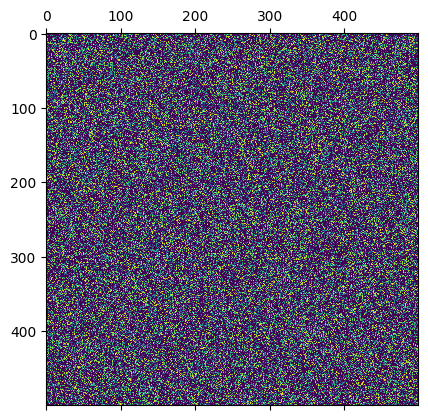

In [52]:
m = 500
n = 500
Md = np.random.rand(m*n)
Md[np.random.rand(m*n) < 0.5] = 0
Md = Md.reshape(m, n)
M = csr_matrix(Md)
plt.matshow(Md)

## Měření rychlosti
Pro účel měření rychlosti obou algoritmů jsem využil modul time, konkrétně jeho funkci perf_counter, která vrací aktuální čas v sekundách.

In [126]:
def measure_time(M):
    n_min = min(M.shape)
    x = np.linspace(1, n_min-1, 20, dtype=int)
    y_arp = np.zeros(20)
    y_ran = np.zeros(20)
    repeat_times = 10

    for _ in range(repeat_times):
        for i, k in enumerate(x):
            svd = TruncatedSVD(n_components=k, algorithm="arpack")
            rsvd = TruncatedSVD(n_components=k, algorithm="randomized")

            start = time.perf_counter()
            svd.fit(M)
            end = time.perf_counter()
            y_arp[i] += end - start
            
            start = time.perf_counter()
            rsvd.fit(M)
            end = time.perf_counter()
            y_ran[i] += end - start
    
    y_arp /= repeat_times
    y_ran /= repeat_times
    
    return x, y_arp, y_ran

[  1  27  53  79 105 132 158 184 210 236 263 289 315 341 367 394 420 446
 472 499]
[0.00677924 0.0542624  0.09026396 0.1268533  0.16133337 0.21871635
 0.25004774 0.30731112 0.40338771 0.4141656  0.46197638 0.46236073
 0.49341587 0.51842679 0.52554    0.53971585 0.55851041 0.58534429
 0.60400154 0.63454102]
[0.00825924 0.0318997  0.06649989 0.14568461 0.20343194 0.32188313
 0.38720171 0.48513579 0.62574556 0.63390315 0.69729526 0.7689175
 0.80129438 0.87645104 0.9087593  0.96209628 1.04208885 1.11839729
 1.23471219 1.27636975]


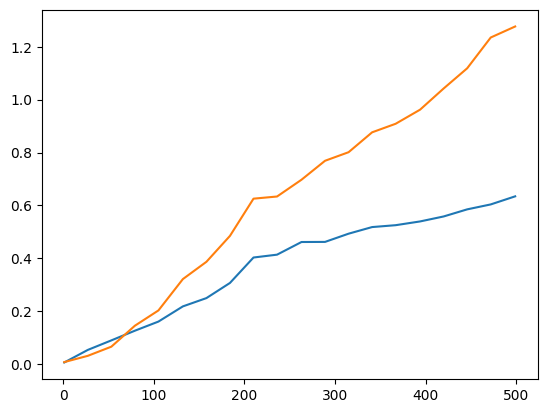

In [127]:
x, y_arp, y_ran = measure_time(M)
print(x)
print(y_arp)
print(y_ran)

fig, ax = plt.subplots()
ax.plot(x, y_arp, x, y_ran)
plt.show()

## Měření paměti
Pro měření využití paměti jsem využil knihovnu psutil, která umožňuje změřit paměťovou náročnost aktuálního procesu.

In [128]:
def current_memory():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss


def measure_memory(M):
    n_min = min(M.shape)
    x = np.linspace(1, n_min-1, 20, dtype=int)
    y_arp = np.zeros(20)
    y_ran = np.zeros(20)
    repeat_times = 10

    for _ in range(repeat_times):
        for i, k in enumerate(x):
            svd = TruncatedSVD(n_components=k, algorithm="arpack")
            rsvd = TruncatedSVD(n_components=k, algorithm="randomized")

            mem_before = current_memory()
            svd.fit(M)
            mem_after = current_memory()
            y_arp[i] += mem_after - mem_before

            mem_before = current_memory()
            rsvd.fit(M)
            mem_after = current_memory()
            y_ran[i] += mem_after - mem_before
    
    y_arp /= repeat_times
    y_ran /= repeat_times
    
    return x, y_arp, y_ran

[  1  27  53  79 105 132 158 184 210 236 263 289 315 341 367 394 420 446
 472 499]
[ 1586790.4 -1216102.4 -1012121.6 -1765376.  -3912908.8   677888.
  1495040.   3878092.8  1518796.8  2909388.8  1236172.8   122470.4
 -1082572.8   768409.6  1467187.2  1595392.   1809612.8  2585804.8
  2387148.8  2573107.2]
[  159334.4   483737.6   569344.    269926.4 -2030796.8 -1766604.8
  -430080.  -3815014.4 -2724659.2  -802406.4  -313344.   2102067.2
    63078.4   713932.8 -1190707.2   -99942.4 -1119436.8  -589824.
 -1315635.2 -3982540.8]


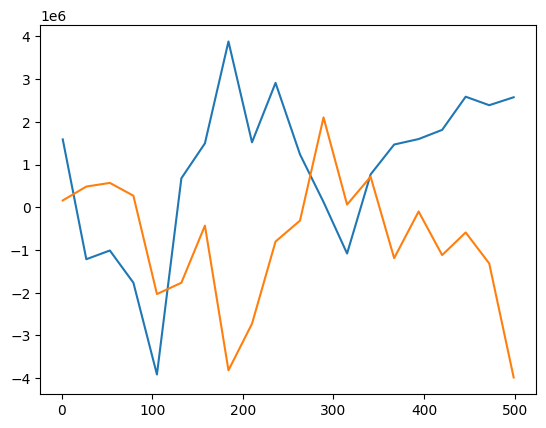

In [129]:
x, y_arp, y_ran = measure_memory(M)
print(x)
print(y_arp)
print(y_ran)

fig, ax = plt.subplots()
ax.plot(x, y_arp, x, y_ran)
plt.show()

## Měření přesnosti aproximace
Přesnost $\epsilon$ aproximované matice $\tilde{M}$ k původní matici $M$ určíme například podle následujícího jednoduchého vzorečku

$$
\begin{equation}
\epsilon = 1 - \frac{\| \tilde{M} - M \|}{\| M \|},
\end{equation}
$$

kde $\| \cdot \|$ označuje Frobeniovu normu matice. Přesnost náleží intervalu $\langle 0, 1 \rangle$. Čím přesnější je aproximace, tím více se $\epsilon$ blíží $100 \%$.

In [134]:
def measure_accuracy(M):
    n_min = min(M.shape)
    x = np.linspace(1, n_min-1, 20, dtype=int)
    y_arp = []
    y_ran = []
    M_dense = M.todense("C")
    norm_exact = np.linalg.norm(M_dense)
    
    for k in x:
        svd = TruncatedSVD(n_components=k, algorithm="arpack")
        M_transformed = svd.fit_transform(M)
        M_tilde = M_transformed @ svd.components_
        norm_diff = np.linalg.norm(M_tilde - M_dense)
        y_arp.append(1 - norm_diff / norm_exact)

        rsvd = TruncatedSVD(n_components=k, algorithm="randomized")
        M_transformed = rsvd.fit_transform(M)
        M_tilde = M_transformed @ rsvd.components_
        norm_diff = np.linalg.norm(M_tilde - M_dense)
        y_ran.append(1 - norm_diff / norm_exact)
    
    return x, y_arp, y_ran

[  1  27  53  79 105 132 158 184 210 236 263 289 315 341 367 394 420 446
 472 499]
[np.float64(0.21086371823402073), np.float64(0.2843687781026475), np.float64(0.35051732491041876), np.float64(0.41212428824571956), np.float64(0.47011719854683054), np.float64(0.5270415941623963), np.float64(0.5789144601563834), np.float64(0.6280644966042919), np.float64(0.6746794003801788), np.float64(0.7186057704921857), np.float64(0.7615608838071576), np.float64(0.8003642855637317), np.float64(0.8366241737491211), np.float64(0.8700705334653123), np.float64(0.9009753860274723), np.float64(0.9294386127918022), np.float64(0.9540687693781882), np.float64(0.9748326720882479), np.float64(0.9907972355070603), np.float64(0.9999893398562669)]
[np.float64(0.2108637182340205), np.float64(0.28271295846401123), np.float64(0.34827371050709877), np.float64(0.4098155979776149), np.float64(0.4678134697016614), np.float64(0.5249969819853743), np.float64(0.5771477541795141), np.float64(0.6264996039466465), np.float64(0.

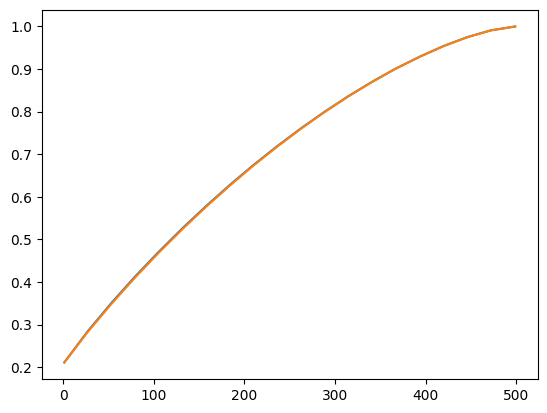

In [135]:
x, y_arp, y_ran = measure_accuracy(M)
print(x)
print(y_arp)
print(y_ran)

fig, ax = plt.subplots()
ax.plot(x, y_arp, x, y_ran)
plt.show()